In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import torchvision
import torch
import numpy as np
import cv2
import os
import time
import os
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io

In [50]:
# get the pretrained model from torchvision.models
# Note: pretrained=True will get the pretrained weights for the model.
# model.eval() to use the model for inference
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample): 

In [51]:
# torch.save(model.state_dict(), "./fasterRCNN")
torch.save(model.state_dict(), "./maskRCNN")

In [52]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [53]:
def get_prediction(img_path, threshold):    
    img = Image.open(img_path)
    transform = T.Compose([T.ToTensor()])
    img = transform(img)
    pred = model([img])
    pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
    pred_score = list(pred[0]['scores'].detach().numpy())
    pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    return pred_boxes, pred_class

In [54]:
def object_detection_api(img_path, threshold=0.5, rect_th=3, text_size=3, text_th=3, fileName ='Seg.png'):
    boxes, pred_cls = get_prediction(img_path, threshold)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     kernel = np.ones((3, 3), np.uint8)
#     img = cv2.dilate(img, kernel, iterations=50)
    print(boxes)
    for i in range(len(boxes)):
        mask = np.zeros(img.shape[:2],np.uint8)
        bgdModel = np.zeros((1,65),np.float64)
        fgdModel = np.zeros((1,65),np.float64)
        rect = (boxes[i][0][0], boxes[i][0][1], boxes[i][1][0],boxes[i][1][1])
        print(rect)
        (mask_grab, bgModel, fgModel) = cv2.grabCut(img, mask, rect, bgdModel, fgdModel, 200, mode = cv2.GC_INIT_WITH_RECT)
        mask2 = np.where((mask_grab == 2) | (mask_grab == 0), 0, 1).astype('uint8')
        outputMask = (mask2 * 255).astype("uint8")
        img_new = img * mask2[:,:,np.newaxis]
        plt.figure(figsize=(20,30))
        plt.imshow((outputMask).astype(np.uint8), cmap = 'gray')
        plt.xticks([])
        plt.yticks([])
        plt.show()
        cv2.imwrite(fileName, outputMask)

    plt.figure(figsize=(20,30))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

[[(47.415337, 70.14988), (301.40567, 300.0)]]
(47.415337, 70.14988, 301.40567, 300.0)


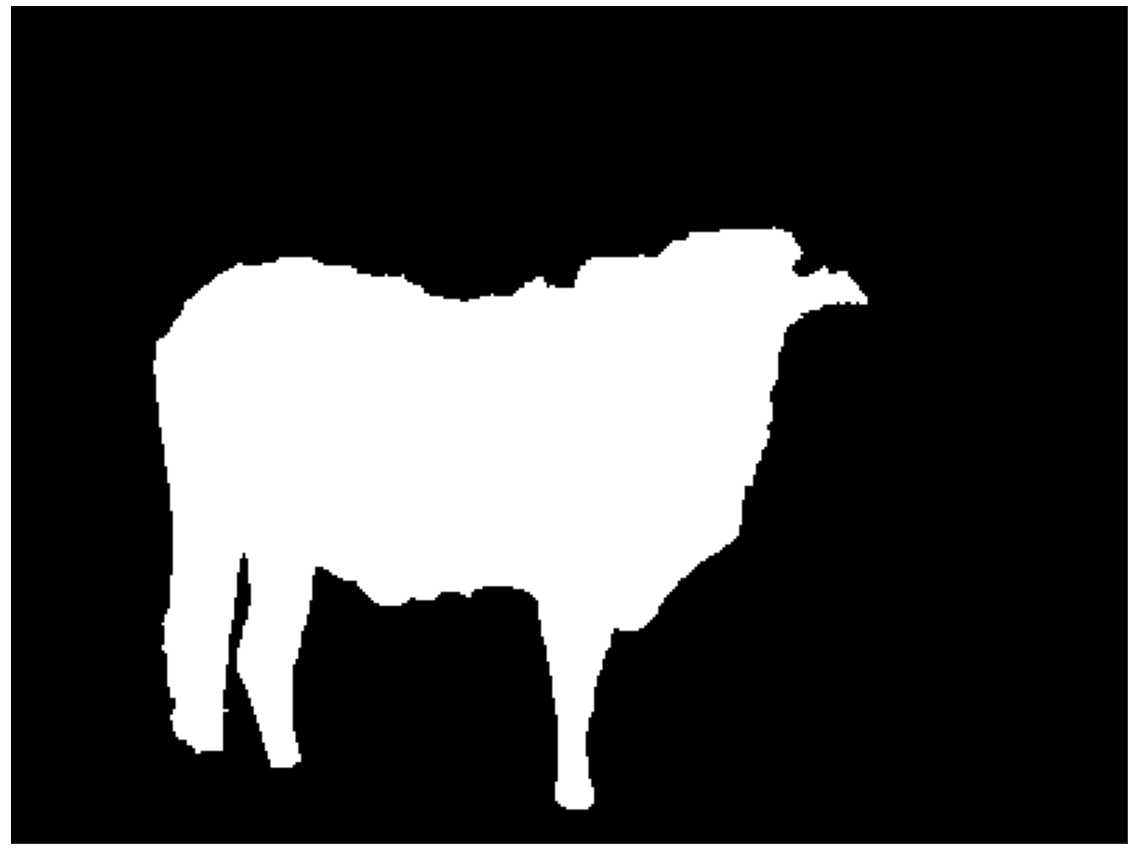

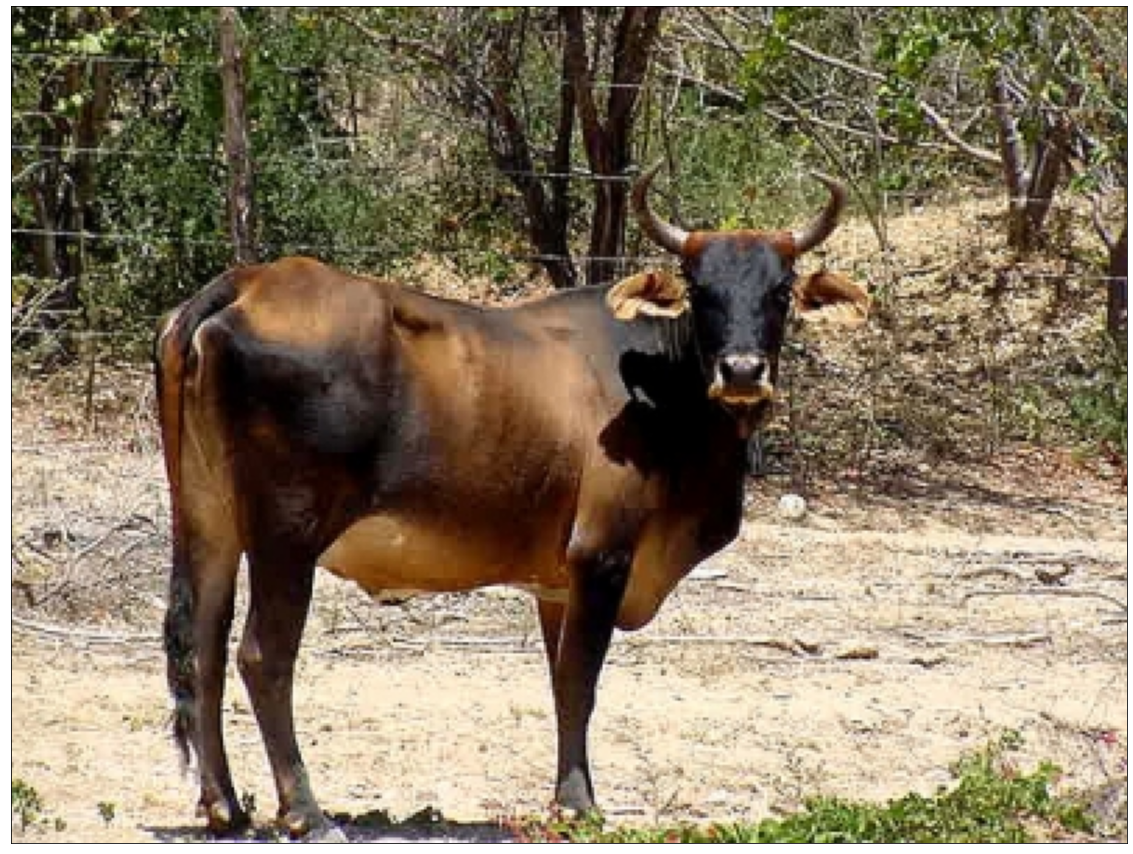

In [55]:
object_detection_api('./Image1.jpg', threshold=0.9, fileName = './Segmented/Backup/Image1_seg.png')
object_detection_api('./Image2.jpg', threshold=0.6, fileName = './Segmented/Backup/Image2_seg.png')
# object_detection_api('./Image3.jpg', threshold=0.09)

[[(106.55168, 7.5474577), (351.7303, 192.79625)]]
(106.55168, 7.5474577, 351.7303, 192.79625)


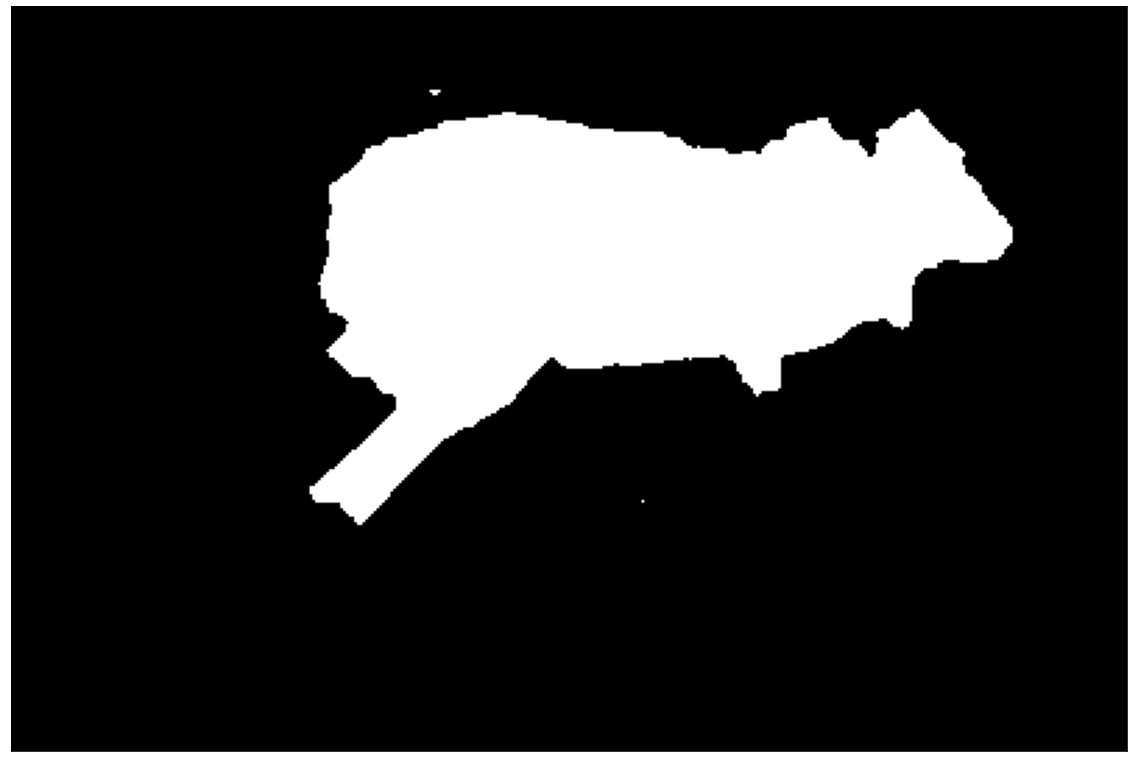

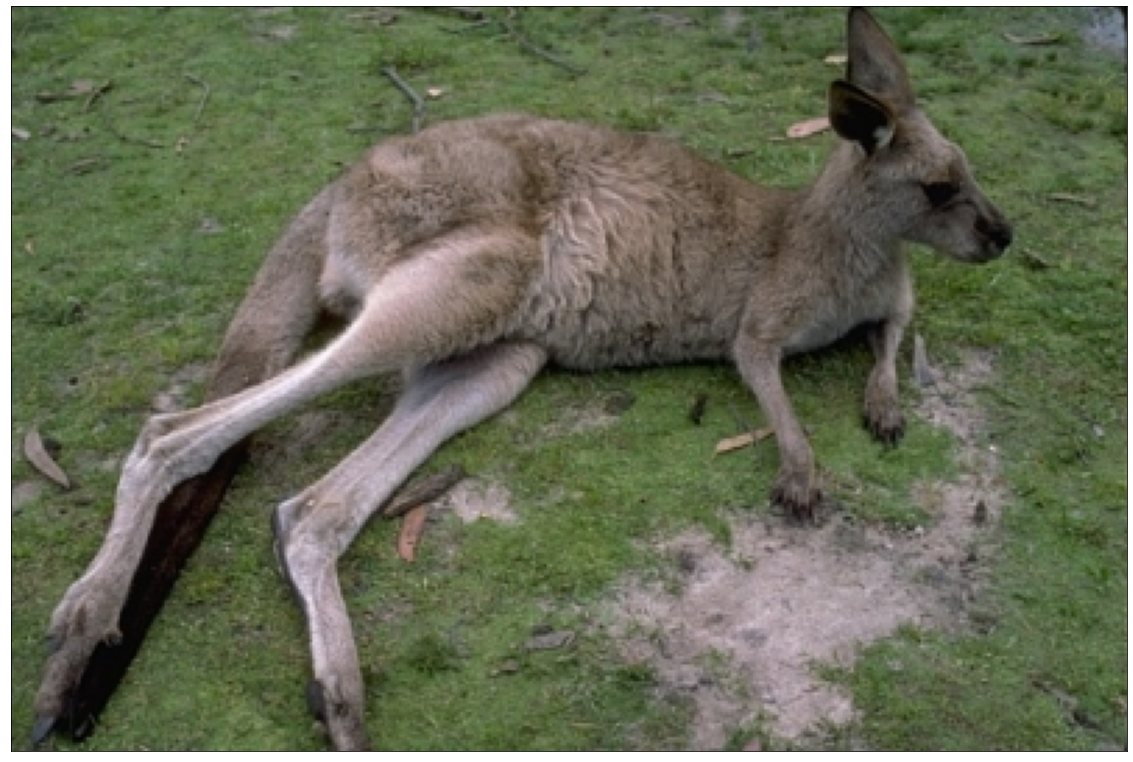

In [56]:
object_detection_api('./Image2.jpg', threshold=0.6)

In [2]:
def super_pixel_segments(image_path, noOfsegments = 5) :
    image = img_as_float(io.imread(image_path))
    segments = slic(image, n_segments = noOfsegments, sigma = 5, convert2lab = True, max_iter=200, compactness=0.01)
    fig = plt.figure("Superpixels -- %d segments%")
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(mark_boundaries(image, segments))
    plt.axis("off")
    plt.show()
    return segments

In [3]:
def image_segmentation(image_path, noOfsegments = 5, fileName='Seg.png', iter = 100) :
    image = cv2.imread(image_path)
    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)
    segments = super_pixel_segments(image_path, noOfsegments)
    mask = np.where(((segments>0) & (segments<255)),cv2.GC_PR_FGD,0).astype('uint8')    
    mask[segments == 0] = cv2.GC_BGD
    mask[segments == 255] = cv2.GC_FGD
    (mask_grab, bgModel, fgModel) = cv2.grabCut(image, mask, None, bgdModel, fgdModel, iter, mode = cv2.GC_INIT_WITH_MASK)
    mask2 = np.where((mask_grab == 2) | (mask_grab == 0), 0, 1).astype('uint8')
    outputMask = (mask2 * 255).astype("uint8")
    plt.figure(figsize=(10,15))
    plt.imshow((outputMask).astype(np.uint8), cmap = 'gray')
    cv2.imwrite(fileName, outputMask)

In [5]:
# image_segmentation('./Image2.jpg', 5, './Segmented/Backup/Image2_seg.png', 100)

C:\Users\PRATAP\miniconda3\envs\MLEnv\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  This is separate from the ipykernel package so we can avoid doing imports until


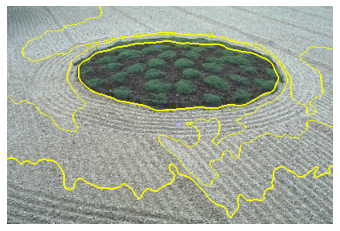

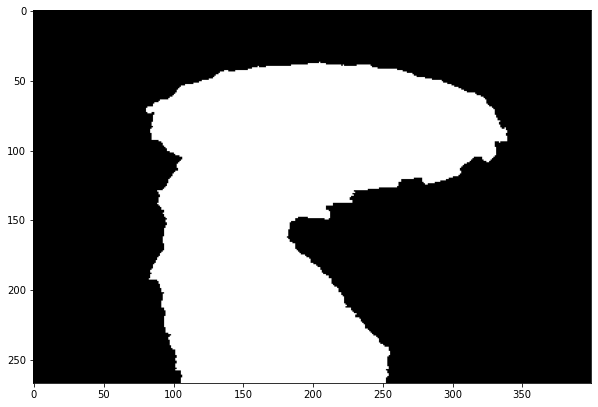

In [60]:
image_segmentation('./Image3.jpg', 5, './Segmented/Backup/Image3_seg.png', 100)